# Log Classification using Machine Learning

In [1]:
import os
os.chdir(r"D:\mgeo\projects\log-classification")

## Importing relevant libraries

In this first cell all necessary classes and functions get imported. Under the hood libraries like keras, sklearn and tensorflow are used but their uses are wrapped in custom methods and classes.

The most important things that are imported in this step are the following: 
- `get_preprocessor` either loads a **Preprocessor** object from a file or creates a new one. The preprocessor contains all information about how data should be preprocessed and brought into a machine readable format. If a new preprocessor is created it will automatically save it to a file to reuse afterwards. This is useful since initializing the used encoders may take some time and loading them from a file should be significantly faster. 
- `get_dataset` either loads a **Dataset** object from a file or creates a new one. The dataset gets created using a preprocessor object which loads log files, preprocesses them and saves them to the dataset. The preprocessing is the most time consuming, therefore it is recommended to load datasets from a file if possible.
- `get_model` creates a new **Classifier** object using a preprocessor and a dataset. The dataset will be split and used for training, validation, evaluation and optionally data augmentation. Once the classifier is trained it can be used to classify raw log data. 
- several encoders that can be passed to the preprocessor to encode data. All encoders are imported even though you will never use all of them at once.

In [2]:
from train_model import get_preprocessor, get_dataset, get_model
from encoders.datetime_encoder import DatetimeEncoder
from encoders.datetime_features import DatetimeFeature
from encoders.loglevel_encoder import LogLevelOrdinalEncoder, LogLevelOneHotEncoder
from encoders.message_encoder import MessageTextVectorizationEncoder, MessageBERTEmbeddingEncoder, MessageBERTEncoder
from encoders.function_encoder import FunctionLabelEncoder, FunctionOneHotEncoder, FunctionOrdinalEncoder
from encoders.classes_encoder import ClassesLabelBinarizer, ClassesLabelEncoder

from util import get_sorted_log_numbers_by_size
from data_augmentation import remove_and_pad

## General configuration and initialization

The path to preprocessor and dataset files are initialized to `None` which means that new ones will be created, this can be optionally changed in a later cell to load them from files instead. 

`VERBOSE` means that more information will be printed to the console or in this case to this notebook. This is True by default, but can be changed to False here if it is unwanted.

`EVALUATION_NAME` is the file path and name of files used for evaluation purposes. Several text and image files will be saved, there may be different suffixes added to the name to differentiate between them. 

`MODEL_TYPE` can be either lstm or transformer. As of now the lstm models achieve significantly better results.

`LOGS_PER_CLASS` will be used when preprocessing the log files and when creating a dataset. It defines how many objects of each class should be attempted to be loaded. While using more data is good, some classes are underrepresented. High LOGS_PER_CLASS has a higher risk of carrying over the underrepresentation to the final dataset. 

`LOGS_TO_LOAD` is a list of numbers of log files to load. You can use the helper function `get_sorted_log_numbers_by_size` to get the smallest or largest log files.

In [3]:
PREPROCESSOR_PATH = DATASET_PATH = None

VERBOSE = True
EVALUATION_NAME = "./evaluations/test"
MODEL_TYPE = "lstm" # or transformer
LOGS_PER_CLASS = 200
LOGS_TO_LOAD = get_sorted_log_numbers_by_size("./data/CCI")[:40]

Here you may optionally set paths to preprocessor or dataset paths. Simply uncomment one of the lines or define the path yourself. 

In [4]:
# large dataset (200 logs per class, 50 logs per window)
PREPROCESSOR_PATH = "./preprocessors/[Etxk7-u9DWzAAcFS][20250819_150015]train_model_pp.json"
DATASET_PATH = "./data/datasets/[20250821_110453]dataset.npz"

# smaller dataset (100 logs per class, 20 logs per window)
# PREPROCESSOR_PATH = "./preprocessors/[Etxk7-u9DWzAAcFS][20250829_112751]train_model_pp.json"# r".\preprocessors\[Etxk7-u9DWzAAcFS][20250821_130907]train_model_pp.json"
# DATASET_PATH = "./data/datasets/[20250829_120602]dataset.npz" #r".\data\datasets\[20250821_134533]dataset.npz"

## Preprocessor, Model and Training Configuration
Here the preprocessor, used models and training can be configured. 

### Preprocessor Configuration

- `name` is a string to identify preprocessors in a human readable way, the name will be present in the filename if the preprocessor is saved
- `window_size` is how many log entries one data point contains. If the window size is 50 for example, each data point will have 50 log entries. If a single log entry has dimension `n`, the data point will have dimension `window_size x n`
- `classes_encoder`, `message_encoder`, `log_level_encoder`, `function_encoder`, `datetime_encoder` are the encoders used by the preprocessor to encode different types of features to machine readable format (numerical tensors) The different types of encoders have different arguments you can pass to them. 
- The `DatetimeEncoder` is special since there is only one kind that is configured by the argument you pass to it. It takes a list of `DatetimeFeature`s that define which part of the feature to use and how to preprocess them.



###  Long Short Term Memory Configuration

The `LSTM_CONFIG` will be used only if the `MODEL_TYPE` set previously is `lstm`. It defines how the LSTM model that is used should be built. 
- The LSTM Model will be built with `layers` layers, each having `units` LSTM units
- `dropout` is the probability that some weights in the LSTM layers will be set to 0 during training to prevent overfitting, `recurrent_drouput` is the same during the recurrent step



### Transformer Configuration

The `TRANSFORMER_CONFIG` will be used only if the `MODEL_TYPE` set previously is `transformer`. It defines how the transformer model that is used should be built. 
- `transformer_layers` is the amount of layered transformer blocks to use
- `model_dim` is the dimension of the transformer blocks
- `num_heads` is the amount of attention heads used for self attention
- `ff_dim` is the dimension of the FFN inside the transformer blocks
- `dropout` is the probability that some weights will be set to 0 during training to prevent overfitting
- `hidden_units` is the dimension of the output in the hidden layer



### Classifier Configuration

The `CLASSIFIER_CONFIG` contains general configuration settings for the classifier mainly used for training. Since they are used for training you could argue that they are Training configurations, however the Classifier needs these values at initialization and not only when training.
- `data_split_ratios` is a tuple defining a ratio by which to split the dataset. The wights of the split are in the following order
  - **training data** to train the model on
  - **validation data** to validate during training
  - **test data** for evaluation after training
  - **pseudolabel data** to be used without labels during Semi Supervised Learning with Pseudolabels
- `learning_rate` is the learning rate used by the optimizer
- `metrics` is a list of metrics to be tracked when training the model
- `seed` is a seed for random modules you may set, optionally use `None` for no seed/random seed



### Training Configuration

- `epochs` is the maximum amount of epochs to train for
- `batch_size`
- parameters prefixed with `es_` are used for Early Stopping, so that when a criteria is filled, the training stops before the maximum amount of `epochs`. If you do not want to use Early Stopping, set `es_monitor` to `None`
  - `es_monitor` is the Quantity to be monitored, if this is None no EarlyStopping will be applied
  - `es_patience` defines how many epochs without change are needed to trigger EarlyStopping, If None is specified it will default to epochs//10
  - `es_min_delta` is the minimum change required to be considered an improvement
  - `es_restore_best` defines whether to restore the best weights of the model after an EarlyStopping was triggered. If None is specified it will default to True.
- parameters prefixef with `pl_` are used for pseudolabeling
  - `pl_unlabeled_data` is additional unlabeled data used for pseudolabeling. Either this has to be defined or a split for pseudolabeling when initializing, to enable Pseudolabeling. You may also define both.
  - `pl_interval` is the epoch interval of trying to add new data from pseudolabeling to the training data. 
  - `pl_confidence_threshold` is how much confidence a prediction is required to have for it to be considered for a pseudolabel and added to the labeled data
- `data_augmentation_functions` is a list of tuples of floats and callables. The floats define the probability that a pseudolabeling function will be used. The function needs to accept four parameters: x, y, all_x, all_y and return a tuple new_x, new_y

###

In [ ]:
# only used if PREPROCESSOR_PATH is None and a new preprocessor is created
PREPROCESSOR_CONFIG = {
    "name": "test_pp",
    "window_size":       50,
    "classes_encoder":   ClassesLabelEncoder(),
    "message_encoder":   MessageBERTEmbeddingEncoder(output_mode="cls"),
    "log_level_encoder": LogLevelOneHotEncoder(),
    "function_encoder":  FunctionOrdinalEncoder(),
    "datetime_encoder":  DatetimeEncoder([
                            DatetimeFeature.hour.cyclic.normalized
                         ])
}

# only used if MODEL_TYPE == "lstm"
LSTM_CONFIG = {
    "lstm_layers":         1,
    "units":              50,
    "dropout":           0.0,
    "recurrent_dropout": 0.0,
}

# only used if MODEL_TYPE == "lstm"
TRANSFORMER_CONFIG = {
    "transformer_layers": 2,
    "model_dim":          128,
    "num_heads":          4,
    "ff_dim":             256,
    "dropout":            0.1,
    "hidden_units":       64,
}


CLASSIFIER_CONFIG = {
    "data_split_ratios": (6, 1, 1, 0),
    "learning_rate":     0.001,
    "metrics":           ["accuracy"],
    "seed":              None,
}

TRAINING_CONFIG = {
    "epochs":                  1000, 
    "batch_size":              32,

    "es_monitor":              "val_loss",
    "es_patience":             500,
    "es_restore_best":         True,
    "es_min_delta":            0.001,

    "pl_unlabeled_data":       None,
    "pl_interval":             10,
    "pl_confidence_threshold": 32,

    "data_augmentation_functions": [
        (0.2, lambda x, y, _1, _2: remove_and_pad(x, y))
    ]
}


## Loading Preprocessor and Dataset

In [6]:
preprocessor = get_preprocessor(
    PREPROCESSOR_PATH or PREPROCESSOR_CONFIG,
    LOGS_TO_LOAD,
    verbose=VERBOSE
    )

Loading preprocessor...

Loading preprocessor from file: ./preprocessors/[Etxk7-u9DWzAAcFS][20250819_150015]train_model_pp.json

Preprocessor successfully loaded.

In [7]:
dataset = get_dataset(
    DATASET_PATH or preprocessor, 
    LOGS_TO_LOAD,
    verbose=VERBOSE, 
    logs_per_class=LOGS_PER_CLASS
    )

Loading dataset...

Loading dataset from file...

dataset successfully loaded.

## Loading and Training a Model

In [8]:
model = get_model(MODEL_TYPE, 
                  LSTM_CONFIG if MODEL_TYPE == "lstm" else TRANSFORMER_CONFIG,
                  CLASSIFIER_CONFIG,
                  preprocessor,
                  dataset)

In [9]:
# train model
model.train(**TRAINING_CONFIG)

es_monitor = 'val_loss'
Epoch 1/1000


d:\mgeo\projects\log-classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2610 - loss: 1.4572 - val_accuracy: 0.2000 - val_loss: 1.4336
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2353 - loss: 1.4242 - val_accuracy: 0.2000 - val_loss: 1.4234
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2379 - loss: 1.4205 - val_accuracy: 0.1800 - val_loss: 1.4205
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2642 - loss: 1.3913 - val_accuracy: 0.1700 - val_loss: 1.3907
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2710 - loss: 1.3785 - val_accuracy: 0.2400 - val_loss: 1.3867
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3109 - loss: 1.3779 - val_accuracy: 0.2200 - val_loss: 1.4225
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2827 - loss: 1.3758 - val_accuracy: 0.2000 - val_loss: 1.4068
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2664 - loss: 1.3707 - val_accuracy: 0.2400 

## Evaluating the Model 

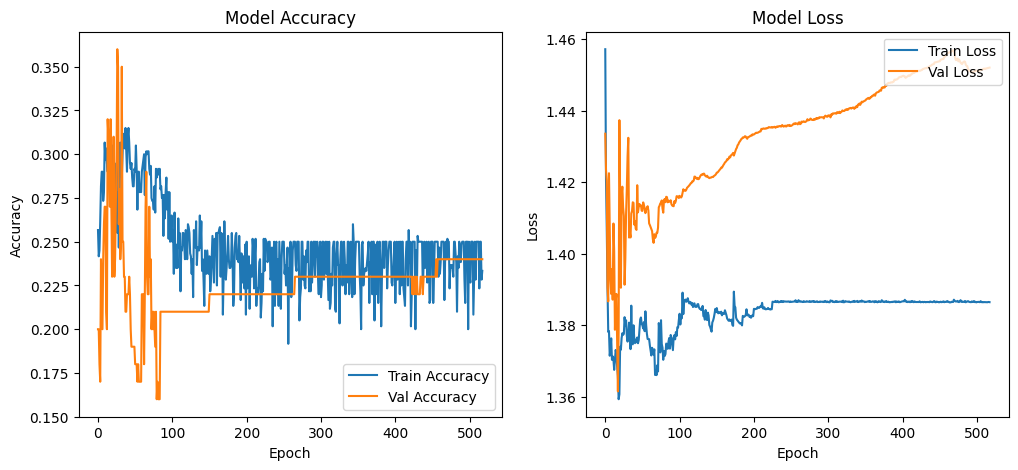

d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

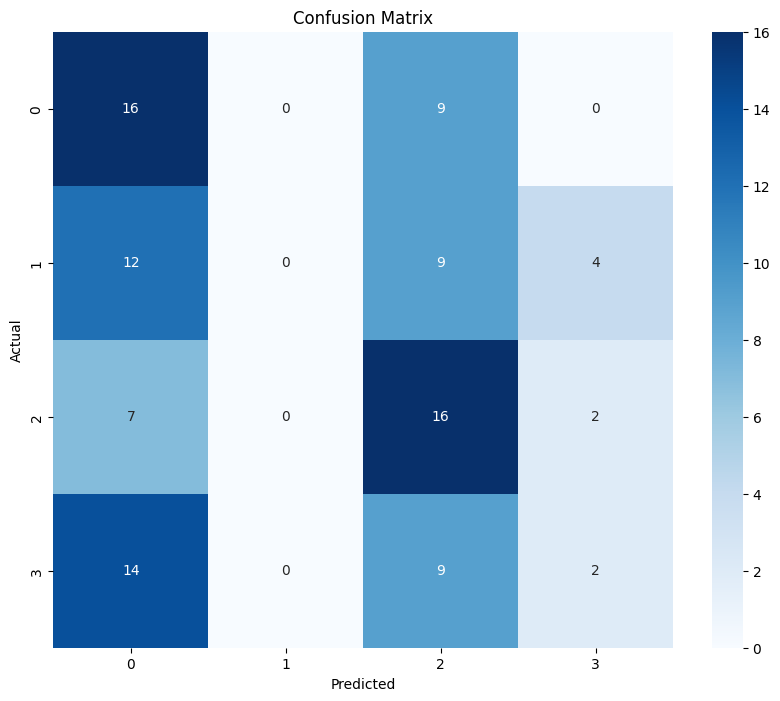

In [10]:
# evaluate model
model.evaluate(EVALUATION_NAME)